### Privacy preserving logistic regression
#### A post-processing example

In this notebook we give examples of performing regression.

Several common formally private noise injection methods depend upon the concept of global sensitivity: how much can a given output change due to adding or deleting a single person across all possible datasets we could observe?

Regression poses a problem for these methods. If we consider a simple ordinary least squares model with a single predictor, we can imagine scenarios where adding or deleting a single person can have a marked effect upon the slope of the regression line. In many cases, this effect can be unbounded.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io
import sklearn
import random
from typing import Union
import statsmodels.api as sm

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Logistic Regression as Post-Processing

We read in data from Louisiana and keep data from PUMA 2400 containing New Orleans.

In [2]:
if 'z' not in locals():
    r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_pla.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract('psam_p22.csv')

keepcols = ['PUMA','RACWHT','PINCP','AGEP','SCHL','MIGPUMA','MIGSP','PWGTP']
pa = pd.read_csv("psam_p22.csv", usecols=keepcols)

In [3]:
#getting data
pa.query('PUMA==2400', inplace=True)

Below is a little bit of the microdata.

In [4]:
def migrecode(migpuma):
    if pd.isnull(migpuma):
        return 0
    else:
        return 1
    
def agerecode(age):
    if age < 18:
        return 0
    else:
        return 1

def schlrecode(schl):
    if schl < 18:
        return 0
    else:
        return 1

pa['MIGRATED']=pa.MIGPUMA.apply(migrecode)
pa['ADULT']=pa.AGEP.apply(agerecode)
pa['COLLEGE']=pa.SCHL.apply(schlrecode)
pa.head()
#print(pa.ADULT.value_counts())

,PUMA,PWGTP,AGEP,SCHL,MIGPUMA,MIGSP,PINCP,RACWHT,MIGRATED,ADULT,COLLEGE
207,2400,11,30,18.0,2390.0,22.0,35000.0,0,1,1,1
208,2400,10,7,4.0,NaN,NaN,NaN,0,0,0,0
275,2400,9,56,22.0,NaN,NaN,68000.0,0,0,1,1
276,2400,14,57,20.0,NaN,NaN,58700.0,0,0,1,1
382,2400,10,26,12.0,NaN,NaN,18000.0,1,0,1,0


We use three binary predictor variables: whether the person is white (already in the data), whether the person is an adult and whether the person has any education beyond high school. We want to predict whether the person migrated from another PUMA.

In [5]:
#feature selection 
#TODO: change Y value to rent or mortage
X = pa[['RACWHT','ADULT','COLLEGE']]
y = pa.MIGRATED

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.416755
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.194   
Dependent Variable: MIGRATED         AIC:              7180.8469
Date:               2019-08-21 12:41 BIC:              7202.0282
No. Observations:   8608             Log-Likelihood:   -3587.4  
Df Model:           2                LL-Null:          -3003.9  
Df Residuals:       8605             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
RACWHT      -0.3559    0.0653   -5.4504  0.0000  -0.4839  -0.2279
ADULT       -1.8148    0.0549  -33.0535  0.0000  -1.9224  -1.7072
COLLEGE 

## Laplace Noise

Define a function to implement the Laplace mechanism.

In [6]:
def laplace_mech(mu: Union[float, np.ndarray], epsilon: int, sensitivity: float = 1.0):
    """
    Implementation of the Laplace Mechanism

    Args:
      mu (float or numpy array): the true answer
      epsilon (int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

Instead of running the regression and adding noise to the coefficients, we do the four-way cross-tabulation of the predictor variables and the response variable. We then add noise to the cross-tab using the Laplace mechanism and an epsilon of 0.25. This is considered the noisy data and is used for the ROC curve. Below, we show the original four-way contingency table and a noisy four-way contingency table.

In [8]:
tab=pd.crosstab(pa.MIGRATED, [pa.RACWHT, pa.ADULT, pa.COLLEGE])
#tab=pd.crosstab(pa.MIGRATED, [pa.RACWHT, pa.ADULT, pa.COLLEGE]).unstack()
noise = laplace_mech(np.zeros(tab.shape), 0.25, 1.0)
noisy_tab = tab + noise
print(tab.unstack())
print(noisy_tab.unstack())

RACWHT  ADULT  COLLEGE  MIGRATED
0       0      0        0            984
                        1            125
               1        0            161
                        1             23
        1      0        0           1806
                        1            193
               1        0           2296
                        1            220
1       0      0        0            358
                        1             37
               1        0             95
                        1             18
        1      0        0            348
                        1             49
               1        0           1603
                        1            292
dtype: int64
RACWHT  ADULT  COLLEGE  MIGRATED
0       0      0        0            982.070453
                        1            126.242059
               1        0            165.454215
                        1             23.175752
        1      0        0           1807.919545
                        1

In [9]:
def avg_l1_laplace(epsilon, mu, sensitivity=1.0, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*mu.sum()))
        total += accuracy
    return total/n


Once you have added noise to the counts, the differential privacy is done. These counts (unrounded) are considered protected, and you can do anything you want with them (including release them as shown above) without using additional privacy loss budget. We will turn them back into microdata and do the desired regression, but everything from here on is post-processing. As such, the ROC curve is calculated on the unrounded noisy counts.

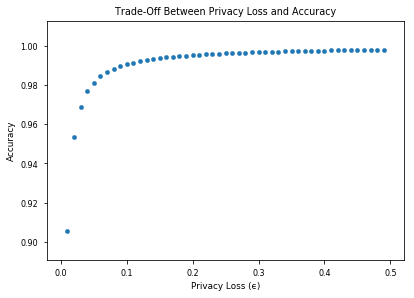

In [11]:
orig_arr = tab.unstack().values
accuracy_df = pd.DataFrame()
eps_range = np.arange(0.01,0.5,0.01)
accuracy_df['Privacy Loss (ϵ)'] = eps_range
#print(avg_l1_laplace(1, orig_arr))

accuracy_df['Accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('Privacy Loss (ϵ)', 'Accuracy')
plt.title('Trade-Off Between Privacy Loss and Accuracy')
plt.style.use('seaborn-paper')
plt.savefig('out/fig.png',facecolor='w', edgecolor='w',
        orientation='portrait', ransparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

We now round each cell in the noisy table to the nearest nonnegative integer. From this, we can reconstruct a noisy microdata set. This step and anything subsequently done to the data are post-processing.

In [15]:
def post_process(tab_values: np.array):
    tab_values[tab_values < 0] = 0
    return tab_values.round().astype('int')

def reconstruct(noisy_tab):
    noisy_unstack = noisy_tab.unstack()
    reps = post_process(noisy_unstack.values)
    colnames = noisy_unstack.index.names
    combinations = noisy_unstack.index.get_values()
    combinations = np.matrix([list(tup) for tup in combinations])
    noisy_microdata = pd.DataFrame(np.repeat(combinations, reps, axis=0),
                                  columns=colnames)
    return noisy_microdata

noisy_microdata = reconstruct(noisy_tab)
#print(noisy_microdata.ADULT.value_counts())
#print(post_process(noisy_tab))

We now run the regression on the noisy microdata.

In [16]:
X = noisy_microdata[['RACWHT','ADULT','COLLEGE']]
y = noisy_microdata.MIGRATED

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.417894
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.190   
Dependent Variable: MIGRATED         AIC:              7210.4914
Date:               2019-08-21 13:39 BIC:              7231.6769
No. Observations:   8620             Log-Likelihood:   -3602.2  
Df Model:           2                LL-Null:          -3026.1  
Df Residuals:       8617             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
RACWHT      -0.3552    0.0649   -5.4733  0.0000  -0.4824  -0.2280
ADULT       -1.8252    0.0551  -33.1026  0.0000  -1.9333  -1.7171
COLLEGE 